In [ ]:
!pip install imagehash

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import imagehash
from PIL import Image

import tensorflow as tf
from tensorflow import keras


In [ ]:
train_path = '/content/drive/MyDrive/train'
test_path = '/content/drive/MyDrive/test'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [ ]:
size_images = 200
batch_size = 64

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size=batch_size,           # Number of images in each batch
    seed=32,                         # Optional: Set a random seed for shuffling
    shuffle=True,                    # Shuffle the data during training
    class_mode='categorical'        # Mode for class labels (categorical for one-hot encoding)
)

Found 557 images belonging to 2 classes.


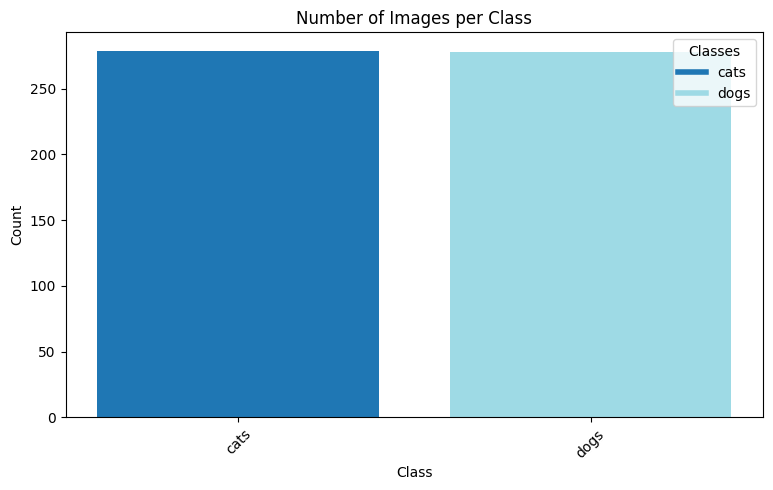

In [ ]:
# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(train_generator)):
    batch_data, batch_labels = train_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(9, 5))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Add a legend for class colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

In [ ]:
# data augmentation for testing
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

In [ ]:

# Create a generator for testing data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')

Found 147 images belonging to 2 classes.


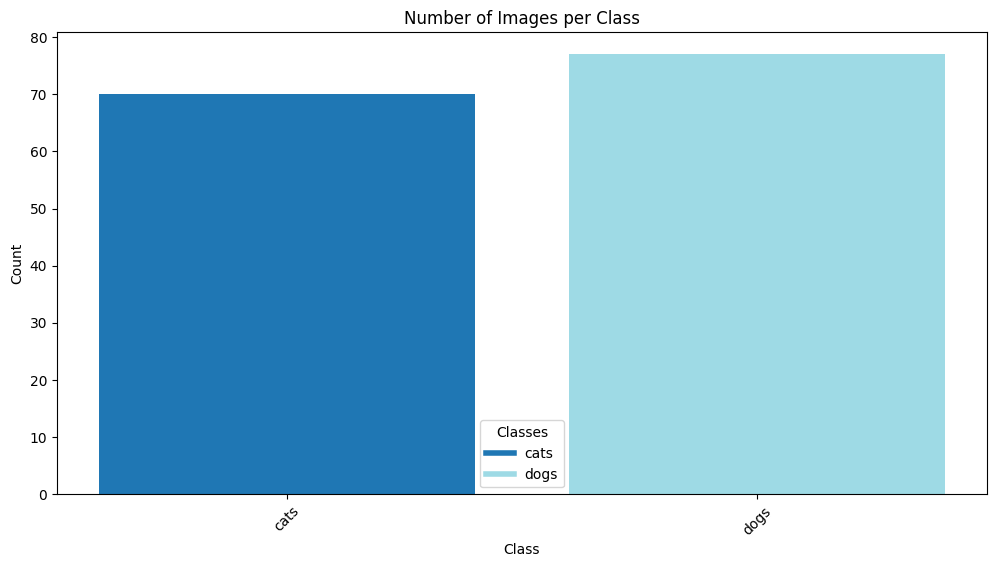

In [ ]:
# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(test_generator)):
    batch_data, batch_labels = test_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(12, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Add a legend for class colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

In [ ]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

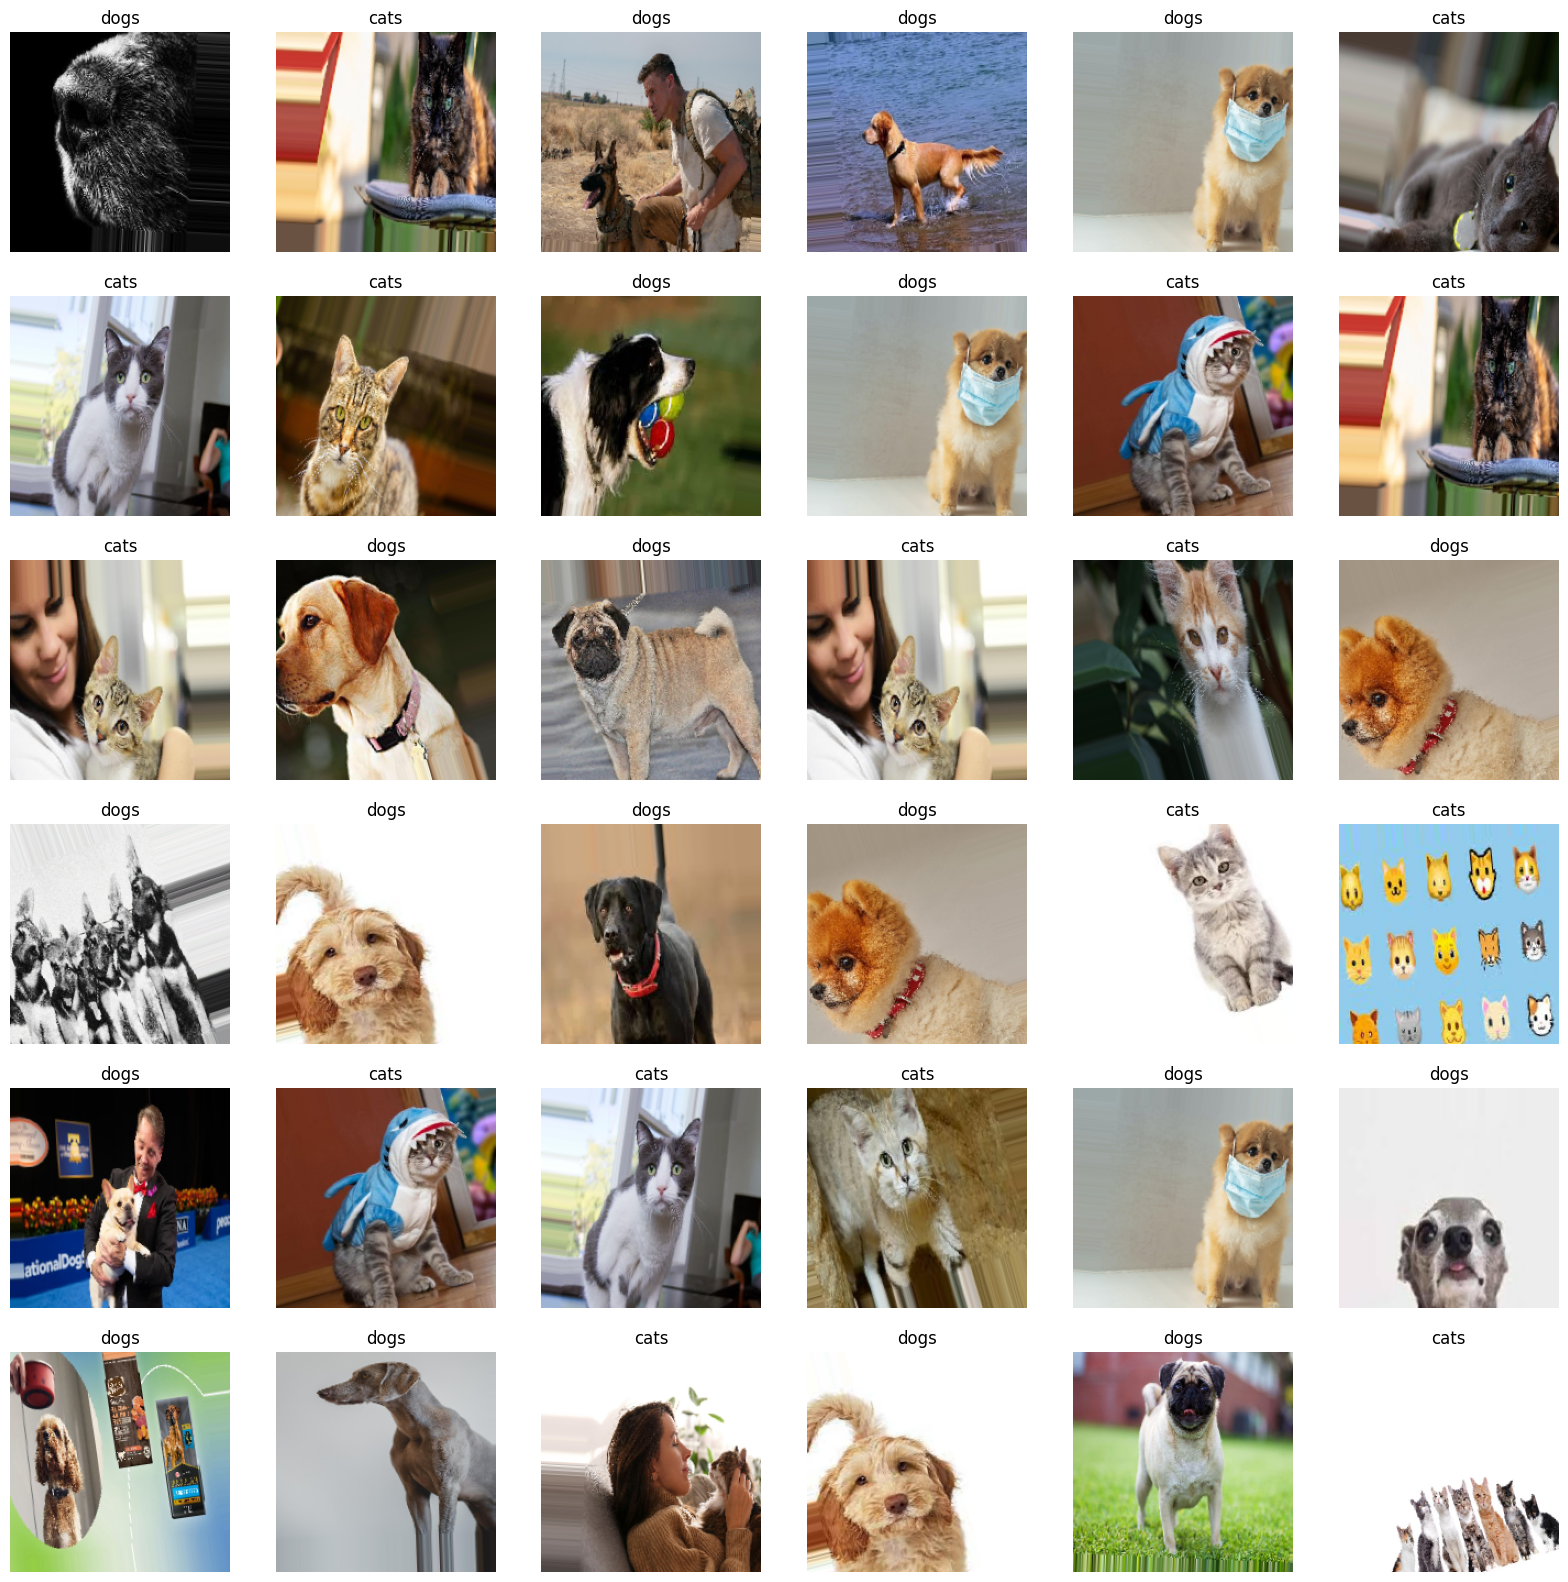

In [ ]:
Show_Images(train_generator)

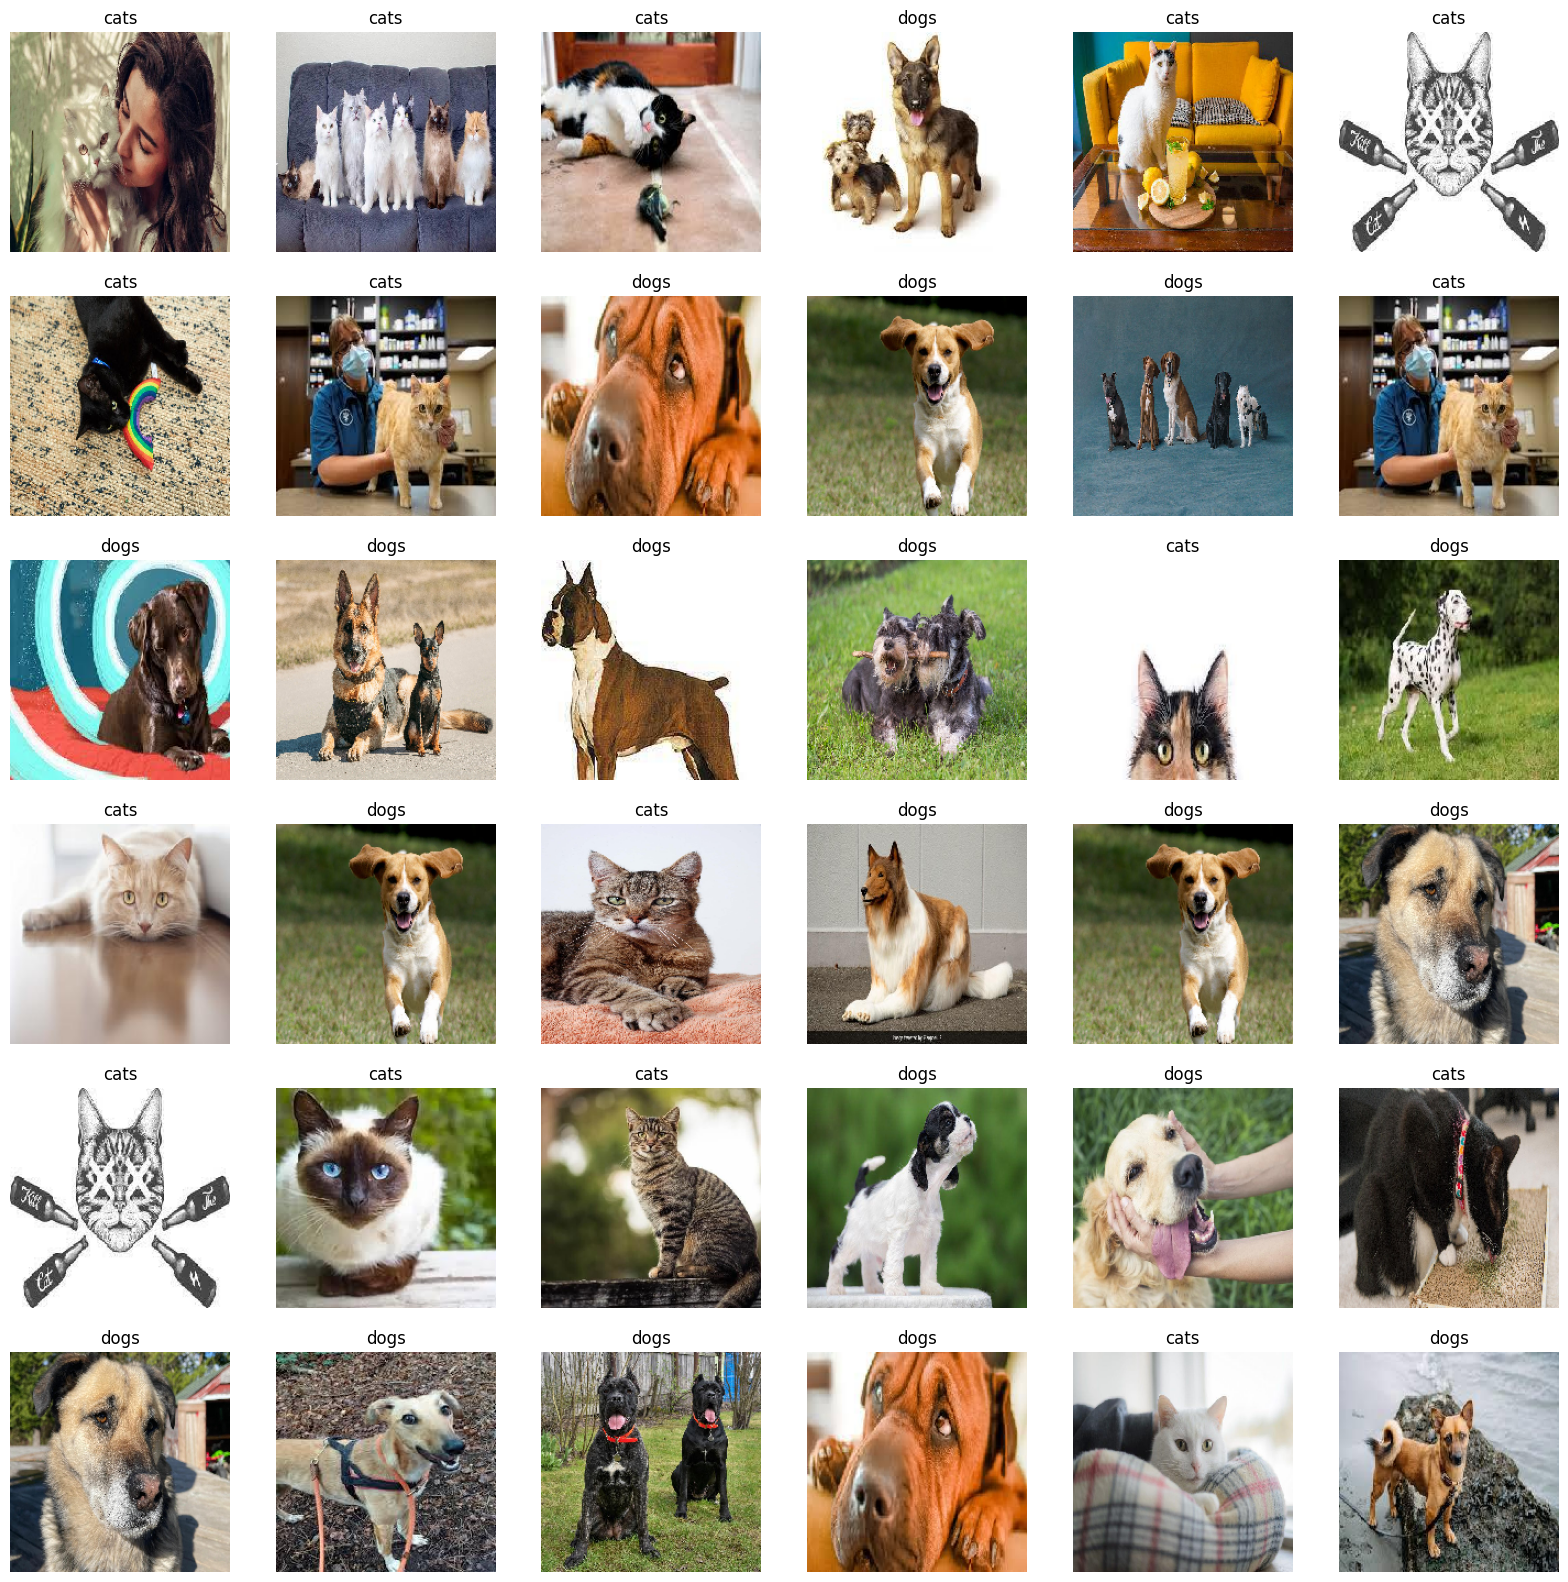

In [ ]:
Show_Images(test_generator)

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
# Configure the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# Create a learning rate schedule using Exponential Decay
learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Initial learning rate for training
    decay_steps=1000,            # Number of steps before decaying the learning rate
    decay_rate=0.5,              # Rate at which the learning rate decreases
)

# learning_rate = initial_learning_rate * decay_rate ^ (global_step / decay_steps)

In [ ]:
from keras.callbacks import LearningRateScheduler

# Create a Learning Rate Scheduler callback using a pre-defined schedule
lr_callback = LearningRateScheduler(learning_rate_schedule)
callback=[ lr_callback , learning_rate_reduce ,early_stopping ]

In [ ]:
from keras.applications import DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model = tf.keras.models.Sequential([
    base_model,

    layers.Flatten(),

    layers.Dense(256,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2,activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 6, 6, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense (Dense)               (None, 256)               9437440   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1

In [ ]:
optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)

In [ ]:
model.compile(optimizer=optimizer,
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[callback]
)

Epoch 1/5
8/8 [==============================] - ETA: 0s - loss: 91.0551 - accuracy: 0.5923 

8/8 [==============================] - 64s 7s/step - loss: 91.0551 - accuracy: 0.5923 - val_loss: 21.2964 - val_accuracy: 0.7656 - lr: 0.0100
Epoch 2/5
8/8 [==============================] - ETA: 0s - loss: 8.7997 - accuracy: 0.8702 

8/8 [==============================] - 65s 8s/step - loss: 8.7997 - accuracy: 0.8702 - val_loss: 21.4105 - val_accuracy: 0.7891 - lr: 0.0099
Epoch 3/5
8/8 [==============================] - ETA: 0s - loss: 3.8546 - accuracy: 0.9102

8/8 [==============================] - 70s 9s/step - loss: 3.8546 - accuracy: 0.9102 - val_loss: 4.6153 - val_accuracy: 0.9141 - lr: 0.0098
Epoch 4/5
8/8 [==============================] - ETA: 0s - loss: 1.6292 - accuracy: 0.9391

8/8 [==============================] - 59s 7s/step - loss: 1.6292 - accuracy: 0.9391 - val_loss: 2.1030 - val_accuracy: 0.9219 - lr: 0.0098
Epoch 5/5
8/8 [==============================] - ETA: 0s - loss: 0.6824 - accuracy: 0.9277

8/8 [==============================] - 69s 9s/step - loss: 0.6824 - accuracy: 0.9277 - val_loss: 1.1835 - val_accuracy: 0.9062 - lr: 0.0097


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint


checkpoint = ModelCheckpoint('best_model_weights.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)


history = model.fit(train_generator,
                    epochs=5,
                    callbacks=[checkpoint],
                    validation_data=test_generator)

Epoch 1/5
9/9 [==============================] - ETA: 0s - loss: 0.2691 - accuracy: 0.9623
Epoch 1: val_accuracy improved from -inf to 0.87755, saving model to best_model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 63s 7s/step - loss: 0.2691 - accuracy: 0.9623 - val_loss: 1.6374 - val_accuracy: 0.8776
Epoch 2/5
9/9 [==============================] - ETA: 0s - loss: 0.3324 - accuracy: 0.9461
Epoch 2: val_accuracy improved from 0.87755 to 0.91156, saving model to best_model_weights.h5
9/9 [==============================] - 70s 8s/step - loss: 0.3324 - accuracy: 0.9461 - val_loss: 0.3915 - val_accuracy: 0.9116
Epoch 3/5
9/9 [==============================] - ETA: 0s - loss: 0.2058 - accuracy: 0.9408
Epoch 3: val_accuracy did not improve from 0.91156
9/9 [==============================] - 70s 8s/step - loss: 0.2058 - accuracy: 0.9408 - val_loss: 0.5820 - val_accuracy: 0.9048
Epoch 4/5
9/9 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.9569
Epoch 4: val_accuracy did not improve from 0.91156
9/9 [==============================] - 60s 7s/step - loss: 0.0883 - accuracy: 0.9569 - val_loss: 0.3175 - val_accuracy: 0.9116
Epoch 5/5
9/9 [========

In [ ]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4948453903198242
Test accuracy: 0.9115646481513977


<Figure size 640x480 with 0 Axes>

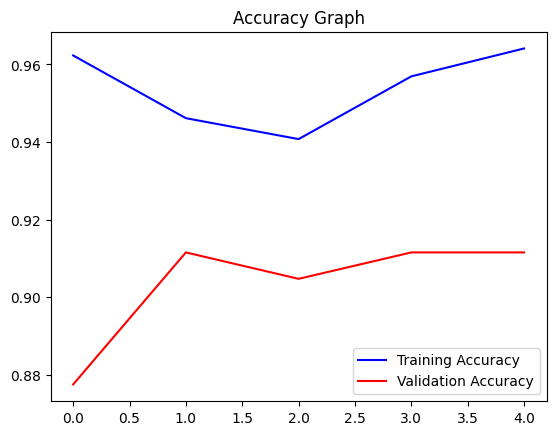

<Figure size 640x480 with 0 Axes>

In [ ]:

# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

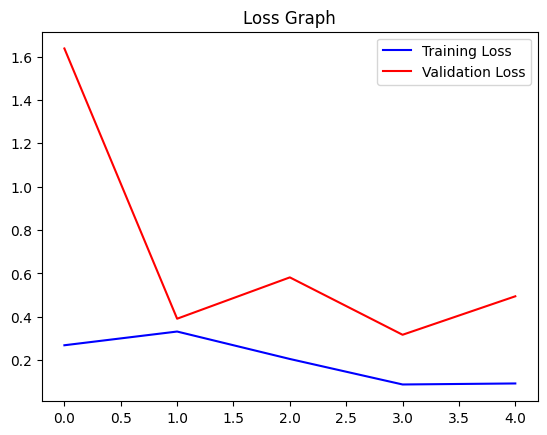

In [ ]:

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

3/3 [==============================] - 13s 3s/step


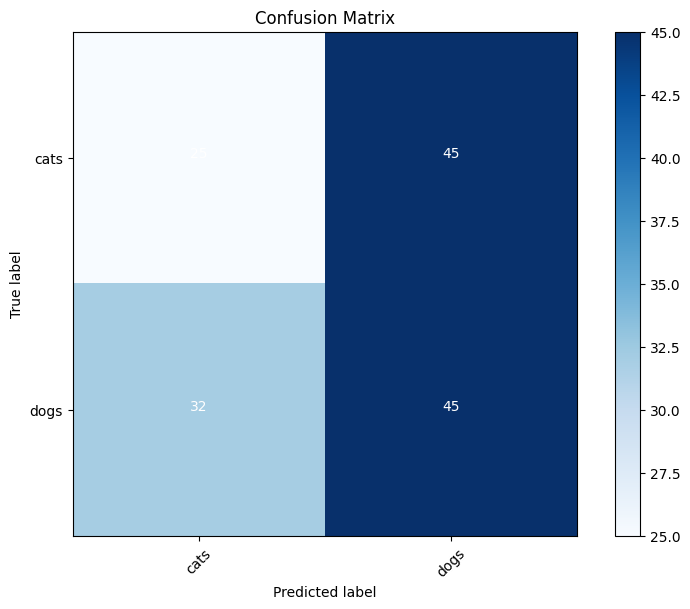

In [ ]:
# Confusion Matrix
import itertools

# Make predictions on the test data
predictions = model.predict(test_generator)

# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the test_generator
true_labels = test_generator.classes

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class names (assuming you have class_names defined)
class_names = test_generator.class_indices.keys()

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")
plt.show()

3/3 [==============================] - 12s 3s/step


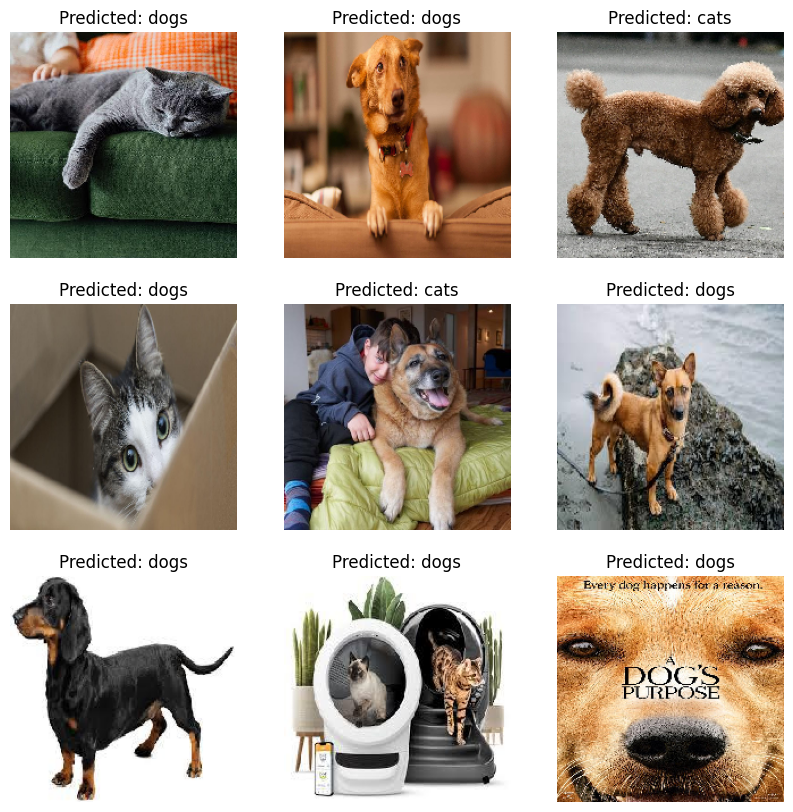

In [ ]:
# Generate predictions for the test data
predictions = model.predict(test_generator)

# Retrieve true labels from the generator (assuming class_mode is 'categorical')
true_labels = test_generator.classes

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Plot images with true and predicted labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
  # Get the next batch from the generator
  image_batch, true_label_batch = test_generator.next()
  # Extract the first image and true label from the batch
  image = image_batch[0]
  true_label = np.argmax(true_label_batch[0])  # Assuming one-hot encoding for true labels

  # True label
  true_label = class_labels[true_labels[i]]
  # Predicted label
  predicted_label = class_labels[np.argmax(predictions[i])]
  ax.imshow(image)
  ax.set_title(f'Predicted: {predicted_label}')
  ax.axis('off')

plt.show()